In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import matplotlib as mpl
from scipy.stats import norm

label_size = 15

mpl.rcParams['legend.fontsize'] = label_size - 5
mpl.rcParams['axes.labelsize'] = label_size 

mpl.rcParams['xtick.labelsize'] = label_size - 2
mpl.rcParams['ytick.labelsize'] = label_size - 2

mpl.rcParams['axes.labelpad'] = 10



# Z=.1 FOR THIS DATASET
cluster_df = pd.read_csv("clusterfind_dataset.csv",delimiter=",")
print(cluster_df.columns)
print(cluster_df.shape)

Index(['# id', 'snap_id', 'uid', 'x', 'y', 'z', 'x_pixel', 'y_pixel',
       'i_sector', 'M500_msolh', 'r500_kpch', 'gas_frac', 'star_frac', 'T_kev',
       'Lx_ergs', 'Y500c', 'M_sat_M_cD', 'cshift', 'vx', 'vy', 'vz '],
      dtype='object')
(613, 21)


Next steps:
- do log-log fit to luminosity and temp. to predict mass => expect power-law relationship
- log T = slope * log M + intercept
- log L = slope * log M + intercept

- take logs yourself (base10)
- can you use temperature or luminosity to predict mass?
- plot a PDF of errors (probability density function) or hist. of mass errors
- mass error = logpredicted_mass - logtrue_mass
- should see mass errors as gaussian

In [2]:
M500_log = np.log10(cluster_df.M500_msolh)
Lx_log = np.log10(cluster_df.Lx_ergs)
Tkev_log = np.log10(cluster_df.T_kev)

coeffs = np.polyfit(M500_log,Lx_log,deg=1)
M500_x_Lx_line = np.poly1d(coeffs)
M500_x_Lx_fit = np.polyval(p=coeffs,x=M500_log)

coeffs = np.polyfit(M500_log,Tkev_log,deg=1)
M500_x_TkeV_line = np.poly1d(coeffs)
M500_x_TkeV_fit = np.polyval(p=coeffs,x=M500_log)

In [3]:
# FROM SINGH (IN PROGRESS)

log_Lx_fit_singh = 1.74*(M500_log)-24.81
log_Tkev_fit_singh = 0.61*(M500_log)-8.25

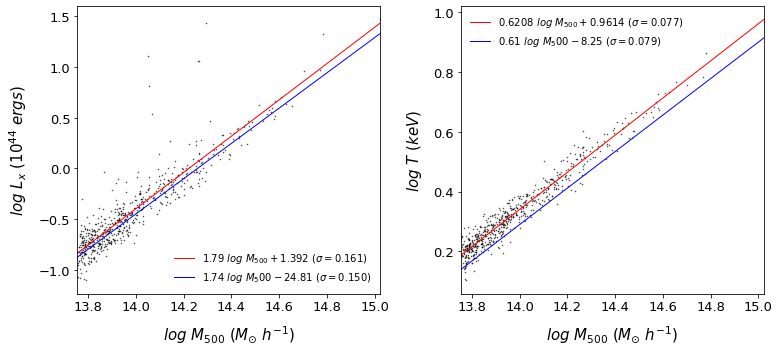

In [4]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(11,5))

Lx_singh_std = np.std(log_Lx_fit_singh-M500_log)
Tkev_singh_std = np.std(log_Tkev_fit_singh-M500_log)

Lx_fit_std = np.std(M500_x_Lx_fit-M500_log)
Tkev_fit_std = np.std(M500_x_TkeV_fit-M500_log)

axes[0].plot(M500_log,M500_x_Lx_fit,color='red',lw=1,label='$1.79 {} + 1.392 \\ (\sigma={:.3f})$'.format('\\ log \\ M_{500}',Lx_fit_std))
axes[0].plot(M500_log,
             log_Lx_fit_singh,
             color='blue',
             lw=1,
             label='$1.74 \\ log \\ M_{:} - 24.81 \\ (\sigma={:.3f})$'.format(500,Lx_singh_std))
axes[0].scatter(M500_log,Lx_log,s=1,color='black',alpha=0.75,marker=".",label='')
axes[0].set_xlabel("$log \\ M_{500} \\ (M_{\odot}\\ h^{-1})$")
axes[0].set_ylabel("$log \\ L_{x} \\ (10^{44} \\ ergs)$")
axes[0].plot()


axes[1].plot(M500_log,M500_x_TkeV_fit,color='red',lw=1,label='$0.6208 {} + 0.9614 \\ (\sigma={:.3f})$'.format('\\ log \\ M_{500}',Tkev_fit_std))
axes[1].plot(M500_log,
             log_Tkev_fit_singh,
             color='blue',
             lw=1,
             label='$0.61 \\ log \\ M_{:} - 8.25 \\ (\sigma={:.3f})$'.format(500,Tkev_singh_std))
axes[1].scatter(M500_log,Tkev_log,s=1,color='black',alpha=0.75,marker=".",label='')
axes[1].set_xlabel("$log \\ M_{500} \\ (M_{\odot}\\ h^{-1})$")
axes[1].set_ylabel("$log \\ T \\ (keV)$")
axes[1].set_xlim(min(M500_log),max(M500_log))
axes[0].set_xlim(min(M500_log),max(M500_log))

plt.subplots_adjust(wspace=0.3)
#plt.savefig("cluster_lum-mass.png",dpi=200)
axes[0].legend(frameon=False), axes[1].legend(frameon=False)
plt.tight_layout()
plt.savefig('cluster_fit_ex.png',dpi=300)
plt.show()
plt.close()
# for us luminosity is the independent variable, mass if dependent

 $log M_{500} = \frac{log L_{x} - 1.392}{1.79}$
 
 $log M_{500} = \frac{log T_{keV} - 0.9614}{0.6208}$

In [5]:
# CALCULATION OF ERROR PDFS
Lx_mass_err =((Lx_log-1.392) / 1.79) - M500_log +15
TkeV_mass_err = ((Tkev_log-0.9614) / 0.6208) - M500_log+15

# select log M500 range to fit a normal distribution to errors
bins = np.arange(-15.3,-14.7,.02)

# FIT NORMAL DIST. TO MASS ERRORS

# fit and calculate average and std
Lx_err_mu, Lx_err_std = norm.fit(Lx_mass_err)
TkeV_err_mu, TkeV_err_std = norm.fit(TkeV_mass_err)
# create normal density from fitted average and std
Lx_err_pdf = norm.pdf(bins, Lx_err_mu, Lx_err_std)
TkeV_err_pdf = norm.pdf(bins, TkeV_err_mu, TkeV_err_std)


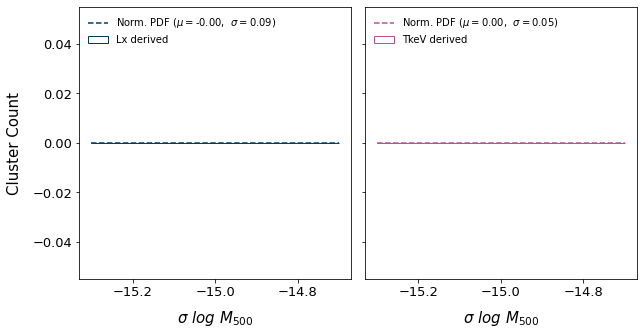

In [6]:
x_label = '$\sigma \\ log \\ M_{500} $'

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5),sharey=True)
normed = True
Lx_n, Lx_bins, _ = ax[0].hist(Lx_mass_err,
                              bins=bins,
                              histtype='step',
                              label='Lx derived',
                              color='#003f5c')
TkeV_n, Lx_bins, _ = ax[1].hist(TkeV_mass_err,
                                bins=bins,
                                histtype='step',
                                label='TkeV derived',
                                color='#bc5090')

# counts in bin / total counts / width of bin (log M)
ax[0].plot(bins,Lx_err_pdf,color='#003f5c',ls='--',label='Norm. PDF ($\mu=${:.2f},  $\sigma=${:.2f})'.format(Lx_err_mu, Lx_err_std))
ax[1].plot(bins,TkeV_err_pdf,color='#bc5090',ls='--',label='Norm. PDF ($\mu=${:.2f},  $\sigma=${:.2f})'.format(TkeV_err_mu, TkeV_err_std))

ax[0].legend(loc='upper left',frameon=False)
ax[1].legend(loc='upper left',frameon=False)

ax[0].set_xlabel('$\sigma \\ log \\ M_{500} $')
ax[1].set_xlabel('$\sigma \\ log \\ M_{500} $')

ax[0].set_ylabel('Cluster Count')

plt.subplots_adjust(wspace=0.05)
plt.savefig('sim_cluster_err_PDFs.png',dpi=200)
plt.show()
plt.close()

Questions
- how do you know that error is on mass and not on luminosity or TkeV?
    - M500 is the dependent variable here

### find scaling law from this paper: https://arxiv.org/pdf/1911.05751.pdf
- uses the same data from PHOX/Magneticum
- look at what variables go into "empirical" (not real obs, mock obs) scaling relations
    - start with mass and temperature (just cause)
    - ignore gass mass
        - confirm that our fitted scaling relation looks like theirs
- don't stress over cosmology details, just be aware
- sanity check for our scaling relations, and improve fluency.
- "fidicual" cosmology=> reference, baseline comosology on Magneticum, some sigma 8, omega matter parameters

- look for Table B1 for M500c relations
- understand Equation 1 (wrestle!)
